In [32]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import tensorflow as tf
# import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [33]:
data_pd = pd.read_csv('../dataset/metadata/HAM10000_metadata.csv')
data_pd.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [34]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [35]:
train_dir = os.path.join('../dataset', 'train_dir')
test_dir = os.path.join('../dataset', 'test_dir')
train_dir

'../dataset/train_dir'

In [36]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization,dataset
lesion_id,,,,,,,
HAM_0000000,2,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1,1


In [37]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [38]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no' 
    else:
        return 'duplicates'

In [39]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicates


In [40]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']
df_count.info()
df_count

<class 'pandas.core.frame.DataFrame'>
Index: 5514 entries, 10 to 10008
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     5514 non-null   object 
 1   image_id      5514 non-null   object 
 2   dx            5514 non-null   object 
 3   dx_type       5514 non-null   object 
 4   age           5467 non-null   float64
 5   sex           5514 non-null   object 
 6   localization  5514 non-null   object 
 7   dataset       5514 non-null   object 
 8   is_duplicate  5514 non-null   object 
dtypes: float64(1), object(8)
memory usage: 430.8+ KB


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,vidir_modern,no
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,vidir_modern,no
20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,vidir_modern,no
33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,vidir_modern,no
34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,rosendahl,no
...,...,...,...,...,...,...,...,...,...
9988,HAM_0001036,ISIC_0027588,akiec,histo,50.0,female,face,rosendahl,no
9990,HAM_0004462,ISIC_0027334,akiec,histo,45.0,male,trunk,vidir_modern,no
9991,HAM_0001152,ISIC_0030133,akiec,histo,65.0,male,face,rosendahl,no
10001,HAM_0000020,ISIC_0031922,akiec,histo,60.0,female,face,rosendahl,no


In [41]:
train, test_df = train_test_split(df_count, test_size=0.20, stratify=df_count['dx'], random_state=42)
train.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4411 entries, 6610 to 4672
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     4411 non-null   object 
 1   image_id      4411 non-null   object 
 2   dx            4411 non-null   object 
 3   dx_type       4411 non-null   object 
 4   age           4375 non-null   float64
 5   sex           4411 non-null   object 
 6   localization  4411 non-null   object 
 7   dataset       4411 non-null   object 
 8   is_duplicate  4411 non-null   object 
dtypes: float64(1), object(8)
memory usage: 344.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1103 entries, 5848 to 5040
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     1103 non-null   object 
 1   image_id      1103 non-null   object 
 2   dx            1103 non-null   object 
 3   dx_type       1103 non-null   object 
 4   ag

In [42]:
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicates,train


In [43]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
5848,HAM_0007134,ISIC_0026394,nv,follow_up,60.0,male,abdomen,vidir_molemax,no
4851,HAM_0003571,ISIC_0026602,nv,follow_up,50.0,female,trunk,vidir_molemax,no
7989,HAM_0004189,ISIC_0033036,nv,histo,40.0,female,unknown,vidir_modern,no
9143,HAM_0002172,ISIC_0024416,nv,histo,65.0,female,back,rosendahl,no
6536,HAM_0001901,ISIC_0026274,nv,follow_up,40.0,female,trunk,vidir_molemax,no


In [44]:
# Image id of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])
print(train_list)

['ISIC_0027419', 'ISIC_0025030', 'ISIC_0026769', 'ISIC_0025661', 'ISIC_0031633', 'ISIC_0027850', 'ISIC_0029176', 'ISIC_0029068', 'ISIC_0025837', 'ISIC_0025209', 'ISIC_0025276', 'ISIC_0029396', 'ISIC_0025984', 'ISIC_0025767', 'ISIC_0032417', 'ISIC_0031326', 'ISIC_0025915', 'ISIC_0031029', 'ISIC_0029836', 'ISIC_0032129', 'ISIC_0032343', 'ISIC_0025033', 'ISIC_0027310', 'ISIC_0032128', 'ISIC_0025937', 'ISIC_0027828', 'ISIC_0029291', 'ISIC_0030698', 'ISIC_0025567', 'ISIC_0031753', 'ISIC_0026835', 'ISIC_0031159', 'ISIC_0031017', 'ISIC_0027815', 'ISIC_0024324', 'ISIC_0029559', 'ISIC_0030661', 'ISIC_0027053', 'ISIC_0028560', 'ISIC_0031650', 'ISIC_0029161', 'ISIC_0026273', 'ISIC_0025076', 'ISIC_0029687', 'ISIC_0025642', 'ISIC_0025819', 'ISIC_0032013', 'ISIC_0031691', 'ISIC_0025419', 'ISIC_0025016', 'ISIC_0029147', 'ISIC_0029301', 'ISIC_0026637', 'ISIC_0030377', 'ISIC_0027960', 'ISIC_0026955', 'ISIC_0028052', 'ISIC_0025286', 'ISIC_0031468', 'ISIC_0030926', 'ISIC_0029288', 'ISIC_0031008', 'ISIC_0

In [45]:
len(test_list)

1103

In [46]:
len(train_list)

8912

In [47]:
data_pd


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicates,train
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,duplicates,train
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,duplicates,train
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,duplicates,train
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,duplicates,train


In [48]:
# Set the image_id as the index in data_pd
data_pd.set_index(['image_id'], inplace=True)

In [49]:
data_pd

,lesion_id,dx,dx_type,age,sex,localization,dataset,is_duplicate,train_test_split
image_id,,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,vidir_modern,duplicates,train
...,...,...,...,...,...,...,...,...,...
ISIC_0033084,HAM_0002867,akiec,histo,40.0,male,abdomen,vidir_modern,duplicates,train
ISIC_0033550,HAM_0002867,akiec,histo,40.0,male,abdomen,vidir_modern,duplicates,train
ISIC_0033536,HAM_0002867,akiec,histo,40.0,male,abdomen,vidir_modern,duplicates,train


In [50]:
# if train_dir does not exist, create it
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

# if test_dir does not exist, create it
if not os.path.exists(test_dir):
    os.makedirs(test_dir)


In [51]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [52]:


for i in targetnames:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.makedirs(directory1, exist_ok=True)
  os.makedirs(directory2, exist_ok=True)

In [53]:
image_dir  = '../dataset/images'

In [54]:
for image in train_list:
    file_name = image + '.jpg'
    print(file_name)
    label = data_pd.loc[image, 'dx']
    print(label)
    # path of source image 
    source = os.path.join(image_dir, file_name)

    # copying the image from the source to target file
    target = os.path.join(train_dir, label, file_name)

    shutil.copyfile(source, target)

ISIC_0027419.jpg
bkl
ISIC_0025030.jpg
bkl
ISIC_0026769.jpg
bkl
ISIC_0025661.jpg
bkl
ISIC_0031633.jpg
bkl
ISIC_0027850.jpg
bkl
ISIC_0029176.jpg
bkl
ISIC_0029068.jpg
bkl
ISIC_0025837.jpg
bkl
ISIC_0025209.jpg
bkl
ISIC_0025276.jpg
bkl
ISIC_0029396.jpg
bkl
ISIC_0025984.jpg
bkl
ISIC_0025767.jpg
bkl
ISIC_0032417.jpg
bkl
ISIC_0031326.jpg
bkl
ISIC_0025915.jpg
bkl
ISIC_0031029.jpg
bkl
ISIC_0029836.jpg
bkl
ISIC_0032129.jpg
bkl
ISIC_0032343.jpg
bkl
ISIC_0025033.jpg
bkl
ISIC_0027310.jpg
bkl
ISIC_0032128.jpg
bkl
ISIC_0025937.jpg
bkl
ISIC_0027828.jpg
bkl
ISIC_0029291.jpg
bkl
ISIC_0030698.jpg
bkl
ISIC_0025567.jpg
bkl
ISIC_0031753.jpg
bkl
ISIC_0026835.jpg
bkl
ISIC_0031159.jpg
bkl
ISIC_0031017.jpg
bkl
ISIC_0027815.jpg
bkl
ISIC_0024324.jpg
bkl
ISIC_0029559.jpg
bkl
ISIC_0030661.jpg
bkl
ISIC_0027053.jpg
bkl
ISIC_0028560.jpg
bkl
ISIC_0031650.jpg
bkl
ISIC_0029161.jpg
bkl
ISIC_0026273.jpg
bkl
ISIC_0025076.jpg
bkl
ISIC_0029687.jpg
bkl
ISIC_0025642.jpg
bkl
ISIC_0025819.jpg
bkl
ISIC_0032013.jpg
bkl
ISIC_0031691.

In [55]:
for image in test_list:

    file_name = image +'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join(image_dir, file_name)

    # copying the image from the source to target file
    target = os.path.join(test_dir, label, file_name)

    shutil.copyfile(source, target)

In [56]:
# Define target classes
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


# Function to perform data augmentation
def augment_images(source_dir, save_dir, img_class, aug_images=4000, batch_size=50):
    # Creating temporary directories
    aug_dir = '../dataset/aug_dir'
    if not os.path.exists(aug_dir):
        os.mkdir(aug_dir)

    img_dir = os.path.join(aug_dir, 'img_dir')
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    img_list = os.listdir(os.path.join(source_dir, img_class))

    # Copy images from the class dir to the img_dir
    for file_name in img_list:
        source = os.path.join(source_dir, img_class, file_name)
        target = os.path.join(img_dir, file_name)
        shutil.copyfile(source, target)

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    aug_datagen = datagen.flow_from_directory(
        aug_dir,
        save_to_dir=save_dir,
        save_format='jpg',
        target_size=(224, 224),
        batch_size=batch_size
    )

    # Generate augmented images
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # Delete temporary directory
    shutil.rmtree(aug_dir)

# Perform data augmentation on training and test datasets
for img_class in targetnames:
    print(f"Augmenting training images for class: {img_class}")
    augment_images(train_dir, os.path.join(train_dir, img_class), img_class)

    # print(f"Augmenting test images for class: {img_class}")
    # augment_images(test_dir, os.path.join(test_dir, img_class), img_class)

print("Data augmentation completed for both training and test datasets.")


Augmenting training images for class: akiec
Found 4011 images belonging to 1 classes.
Augmenting training images for class: bcc
Found 4032 images belonging to 1 classes.
Augmenting training images for class: bkl
Found 4033 images belonging to 1 classes.
Augmenting training images for class: df
Found 4039 images belonging to 1 classes.
Augmenting training images for class: mel
Found 4001 images belonging to 1 classes.
Augmenting training images for class: nv
Found 5822 images belonging to 1 classes.
Augmenting training images for class: vasc
Found 4033 images belonging to 1 classes.
Data augmentation completed for both training and test datasets.


In [57]:
train_dir = os.path.join('../dataset', 'train_dir')
test_dir = os.path.join('../dataset', 'test_dir')

train_path = train_dir
test_path = test_dir
batch_size = 16 

In [58]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [59]:
image_size = 224
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 29971 images belonging to 7 classes.

Test Batches: 
Found 1103 images belonging to 7 classes.


In [60]:
# show train_batch
imgs, labels = next(train_batches)

labels


array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [61]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()
 

In [1]:
densenet = tf.keras.applications.DenseNet121(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,

)
# Exclude the last 28 layers of the model.
conv = densenet.layers[-28].output

NameError: name 'tf' is not defined

Soft Attention

In [ ]:


attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)


NameError: name 'conv' is not defined

In [ ]:

output = Flatten()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=densenet.input, outputs=output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

NameError: name 'model' is not defined

In [ ]:
class_weights = {   
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 5.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath = 'saved_model2.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)




In [ ]:
import sys
from PIL import Image


In [ ]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=35, min_delta=0.001)
history = model.fit(train_batches,
                    steps_per_epoch=(len(train_df)/10),
                    epochs=150,
                    verbose=2,
                    validation_data=test_batches,validation_steps=len(test_df)/batch_size,callbacks=[checkpoint,Earlystop],class_weight=class_weights)

Epoch 1/150


2024-06-13 20:24:51.447320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-13 20:25:12.720904: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-13 20:25:16.320283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-06-13 20:25:16.842666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-13 20:25:17.184491: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f8340edd0f0 initial

891/891 - 212s - loss: 1.6889 - accuracy: 0.4713 - val_loss: 0.8003 - val_accuracy: 0.7063 - 212s/epoch - 238ms/step
Epoch 2/150
891/891 - 133s - loss: 1.2480 - accuracy: 0.6231 - val_loss: 0.7942 - val_accuracy: 0.7335 - 133s/epoch - 150ms/step
Epoch 3/150
891/891 - 140s - loss: 1.1558 - accuracy: 0.6596 - val_loss: 0.5392 - val_accuracy: 0.7951 - 140s/epoch - 157ms/step
Epoch 4/150
891/891 - 135s - loss: 1.0274 - accuracy: 0.6998 - val_loss: 0.5198 - val_accuracy: 0.8033 - 135s/epoch - 152ms/step
Epoch 5/150
891/891 - 136s - loss: 0.9462 - accuracy: 0.7164 - val_loss: 0.3790 - val_accuracy: 0.8495 - 136s/epoch - 153ms/step
Epoch 6/150
891/891 - 136s - loss: 0.8944 - accuracy: 0.7416 - val_loss: 0.8400 - val_accuracy: 0.6917 - 136s/epoch - 152ms/step
Epoch 7/150
891/891 - 134s - loss: 0.8342 - accuracy: 0.7555 - val_loss: 0.4094 - val_accuracy: 0.8459 - 134s/epoch - 150ms/step
Epoch 8/150
891/891 - 135s - loss: 0.7820 - accuracy: 0.7737 - val_loss: 0.7530 - val_accuracy: 0.7752 - 135s

In [ ]:
from tensorflow.keras import models
model.load_weights("saved_model.hdf5")

In [ ]:
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

2024-07-17 21:40:20.272308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-07-17 21:40:22.101644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-07-17 21:40:22.455712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [ ]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.96      0.83      0.89        30
         bcc       0.97      0.94      0.96        35
         bkl       0.94      0.95      0.95        88
          df       1.00      1.00      1.00         8
         mel       0.91      0.87      0.89        46
          nv       0.99      1.00      0.99       883
        vasc       1.00      0.92      0.96        13

    accuracy                           0.98      1103
   macro avg       0.97      0.93      0.95      1103
weighted avg       0.98      0.98      0.98      1103



In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.9816517590133857
Recall: 0.9818676337262012
Accuracy: 0.9818676337262012
weighted Roc score: 0.998315541738803


In [ ]:

print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.9678464958702896
Recall: 0.9315875807916634
Accuracy: 0.9818676337262012
Macro Roc score: 0.9984425539514079


In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.9818676337262012
Recall: 0.9818676337262012
Accuracy: 0.9818676337262012
Micro Roc score: 0.999443261283343


In [ ]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9987884436160298
The ROC AUC score of bcc is: 0.9988228999464954
The ROC AUC score of bkl is: 0.9955553067622033
The ROC AUC score of df is: 1.0
The ROC AUC score of mel is: 0.9973674468347662
The ROC AUC score of nv is: 0.9985637805003603
The ROC AUC score of vasc is: 1.0


In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

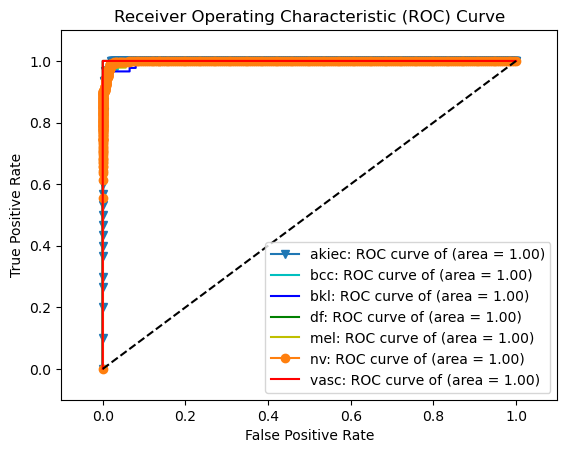

In [ ]:

plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
x_test,y_test=next(test_batches)


# get the soft attention and true and predicted label
sa_model = Model(model.inputs,model.get_layer('soft_attention').output)
sa_features, sa_maps = sa_model.predict(x_test)
y_pred = model.predict(x_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

# show results

y_true, y_pred

1/1 [==============================] - 2s 2s/step


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 5, 0, 0, 0]))

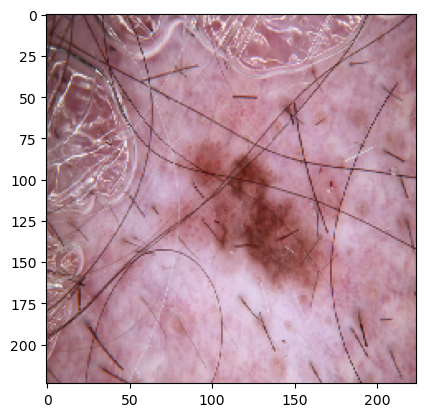

In [ ]:
img_idx = 12
t = (x_test + 1)/2 # bring the range between 0,1 from -1,1
plt.imshow(t[img_idx])
plt.show()

In [ ]:


sum_attnmap = np.sum(sa_maps[img_idx],0)
sum_attnmap.shape


(7, 7)

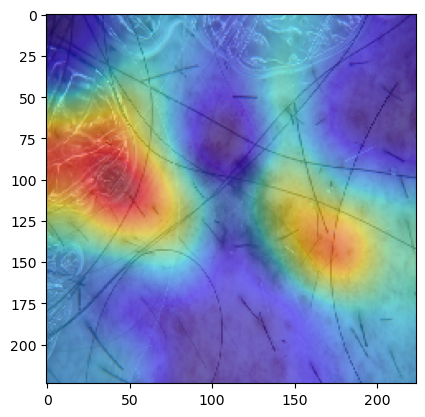

In [ ]:
import cv2
plt.imshow(t[img_idx],alpha=1.0)
plt.imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
plt.show()